
# ASL Sign-MNIST CNN — Refactored (Device-safe, Clean Metrics, Confusion Matrix)

이 노트북은 기존 코드의 구조를 **GPU 메모리 안전성**, **정확한 메트릭 수집**, **표준화/증강**, **재현성** 측면에서 개선한 버전입니다.

**주요 변경점**
- Dataset은 **CPU 텐서**만 보관, **배치 단위**로 `.to(device)` 이동
- `y_trues`, `y_preds`를 **1차원**으로 수집해 `confusion_matrix` 안정화
- `Normalize(mean=[0.5], std=[0.5])` 추가 (또는 데이터셋 통계 기반으로 교체 가능)
- seed 고정, 학습곡선/혼동행렬 시각화 개선
- Early Stopping & Best Model 저장 옵션


In [27]:

import os
import random
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms  # torchvision>=0.15
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [32]:

@dataclass
class Config:
    train_csv: str = 'asl_data/sign_mnist_train.csv'  # 필요 시 경로 수정
    valid_csv: str = 'asl_data/sign_mnist_valid.csv'   # 필요 시 경로 수정
    n_classes: int = 24
    batch_size: int = 64
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 15
    num_workers: int = 0
    save_path: str = 'asl_refactor_best.pt'           # 최고 성능 모델 저장 경로
    use_scheduler: bool = True

cfg = Config()
cfg


Config(train_csv='asl_data/sign_mnist_train.csv', valid_csv='asl_data/sign_mnist_valid.csv', n_classes=24, batch_size=64, lr=0.001, weight_decay=0.0001, epochs=15, num_workers=0, save_path='asl_refactor_best.pt', use_scheduler=True)

In [33]:

class ASLSignMNIST(Dataset):
    """
    CSV 형식: 첫 열이 'label', 이후 28*28 픽셀(0~255)
    """
    def __init__(self, csv_path: str, transform=None):
        df = pd.read_csv(csv_path)
        y = df.iloc[:, 0].values.astype('int64')  # CE Loss에 맞춤
        x = df.iloc[:, 1:].values.astype('float32') / 255.0
        x = x.reshape(-1, 1, 28, 28)  # N, C, H, W

        self.xs = torch.from_numpy(x)       # CPU 텐서
        self.ys = torch.from_numpy(y)       # CPU 텐서
        self.transform = transform

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        img = self.xs[idx]   # (1,28,28), float32 on CPU
        label = self.ys[idx]

        if self.transform is not None:
            img = self.transform(img)  # v2 transforms는 Tensor 입력 지원

        return img, label


In [34]:

# 28x28 손글씨에 너무 과격하지 않은 변환 추천
train_tf = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

valid_tf = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),
])


In [35]:

train_ds = ASLSignMNIST(cfg.train_csv, transform=train_tf)
valid_ds = ASLSignMNIST(cfg.valid_csv, transform=valid_tf)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

train_N = len(train_ds)
valid_N = len(valid_ds)
train_N, valid_N


(27455, 7172)

In [36]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.MaxPool2d(2, 2),
        )
    def forward(self, x):
        return self.net(x)

class ASLCNN(nn.Module):
    def __init__(self, n_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(1, 32, 0.1),   # 28->14
            ConvBlock(32, 64, 0.1),  # 14->7
            ConvBlock(64, 128, 0.1), # 7->3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = ASLCNN(n_classes=cfg.n_classes).to(device)
model


ASLCNN(
  (features): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1,

In [37]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5) if cfg.use_scheduler else None


In [38]:

train_loss_hist, valid_loss_hist = [], []
train_acc_hist, valid_acc_hist = [], []

best_val_acc = 0.0

def train_one_epoch():
    model.train()
    run_loss, run_correct = 0.0, 0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * x.size(0)
        run_correct += (out.argmax(1) == y).sum().item()

    epoch_loss = run_loss / train_N
    epoch_acc = run_correct / train_N
    return epoch_loss, epoch_acc

def validate_one_epoch():
    model.eval()
    run_loss, run_correct = 0.0, 0
    y_trues, y_preds = [], []
    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            out = model(x)
            loss = criterion(out, y)
            run_loss += loss.item() * x.size(0)

            pred = out.argmax(1)  # (B,)
            run_correct += (pred == y).sum().item()

            y_trues.extend(y.cpu().tolist())
            y_preds.extend(pred.cpu().tolist())

    epoch_loss = run_loss / valid_N
    epoch_acc = run_correct / valid_N
    return epoch_loss, epoch_acc, y_trues, y_preds


In [ ]:

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc, y_true, y_pred = validate_one_epoch()

    if scheduler is not None:
        scheduler.step()

    train_loss_hist.append(tr_loss); train_acc_hist.append(tr_acc)
    valid_loss_hist.append(va_loss); valid_acc_hist.append(va_acc)

    # Save best
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        # model.state_dict() → 모델의 학습된 가중치와 버퍼들, cfg.__dict__ → 어떤 설정/하이퍼파라미터로 학습했는지 기록
        torch.save({'model': model.state_dict(),
                    'cfg': cfg.__dict__},
                   cfg.save_path)

    print(f"[{epoch:02d}/{cfg.epochs}] "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"valid loss {va_loss:.4f} acc {va_acc:.4f} "
          f"(best {best_val_acc:.4f})")

print("Best model saved to:", cfg.save_path)


[01/15] train loss 0.5438 acc 0.8381 | valid loss 0.1264 acc 0.9661 (best 0.9661)
[02/15] train loss 0.0536 acc 0.9856 | valid loss 0.0507 acc 0.9911 (best 0.9911)
[03/15] train loss 0.0296 acc 0.9925 | valid loss 0.0401 acc 0.9916 (best 0.9916)
[04/15] train loss 0.0203 acc 0.9942 | valid loss 0.0246 acc 0.9950 (best 0.9950)
[05/15] train loss 0.0176 acc 0.9948 | valid loss 0.0153 acc 0.9978 (best 0.9978)
[06/15] train loss 0.0049 acc 0.9989 | valid loss 0.0125 acc 0.9943 (best 0.9978)
[07/15] train loss 0.0034 acc 0.9995 | valid loss 0.0067 acc 0.9987 (best 0.9987)
[08/15] train loss 0.0053 acc 0.9987 | valid loss 0.0135 acc 0.9951 (best 0.9987)
[09/15] train loss 0.0065 acc 0.9984 | valid loss 0.0081 acc 0.9982 (best 0.9987)
[10/15] train loss 0.0064 acc 0.9983 | valid loss 0.0132 acc 0.9951 (best 0.9987)
[11/15] train loss 0.0023 acc 0.9996 | valid loss 0.0090 acc 0.9971 (best 0.9987)
[12/15] train loss 0.0018 acc 0.9997 | valid loss 0.0179 acc 0.9950 (best 0.9987)
[13/15] train lo

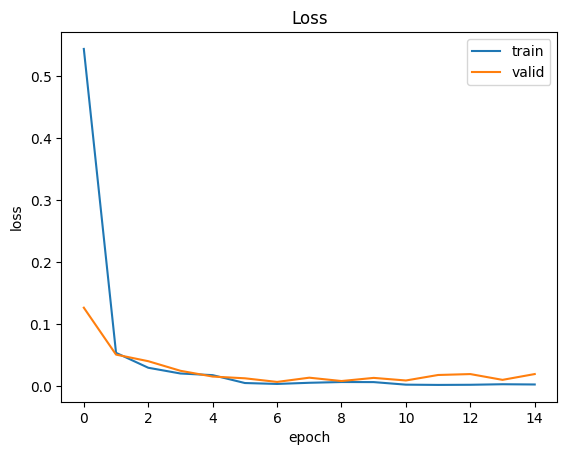

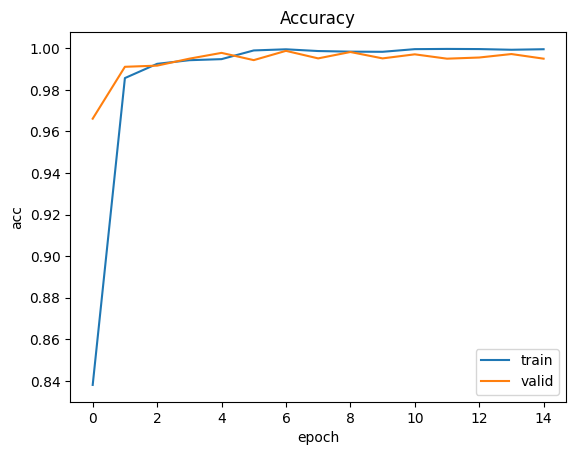

In [40]:

# Loss
plt.figure()
plt.plot(train_loss_hist, label='train')
plt.plot(valid_loss_hist, label='valid')
plt.title('Loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc_hist, label='train')
plt.plot(valid_acc_hist, label='valid')
plt.title('Accuracy')
plt.xlabel('epoch'); plt.ylabel('acc')
plt.legend()
plt.show()


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       331
           1     1.0000    1.0000    1.0000       432
           2     1.0000    1.0000    1.0000       310
           3     1.0000    1.0000    1.0000       245
           4     1.0000    1.0000    1.0000       498
           5     1.0000    1.0000    1.0000       247
           6     1.0000    0.9971    0.9986       348
           7     0.9977    1.0000    0.9989       436
           8     1.0000    1.0000    1.0000       288
           9     1.0000    1.0000    1.0000       331
          10     1.0000    1.0000    1.0000       209
          11     0.9825    1.0000    0.9912       394
          12     1.0000    0.9759    0.9878       291
          13     1.0000    1.0000    1.0000       246
          14     1.0000    1.0000    1.0000       347
          15     1.0000    1.0000    1.0000       164
          16     1.0000    1.0000    1.0000       144
          17     1.0000    

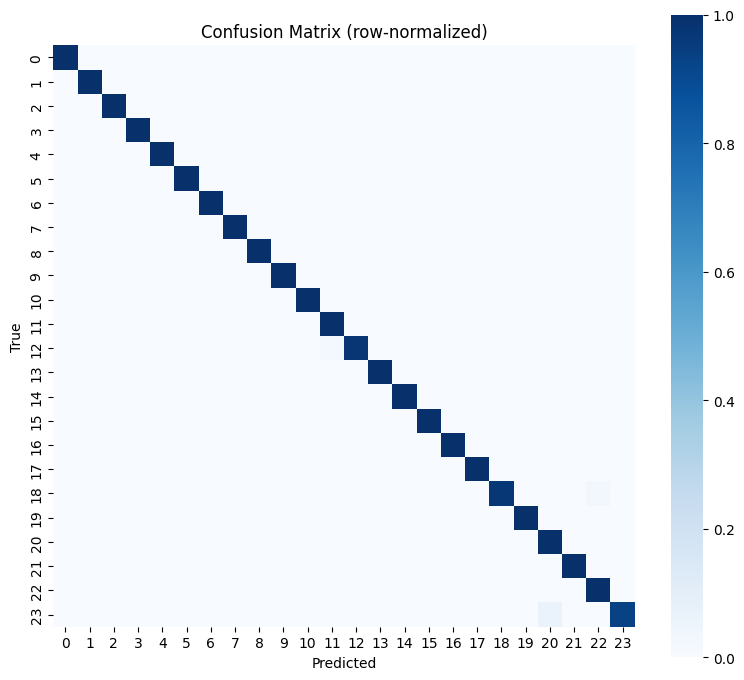

In [41]:

# 마지막 epoch의 y_true, y_pred를 다시 계산해서 출력
_, _, y_true, y_pred = validate_one_epoch()

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(cfg.n_classes)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_norm, annot=False, cmap='Blues', square=True)
plt.title('Confusion Matrix (row-normalized)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()


In [42]:

# 선택: 최고 성능 모델 로드 & 검증 정확도 확인
ckpt = torch.load(cfg.save_path, map_location='cpu')
model.load_state_dict(ckpt['model'])
model.to(device)
va_loss, va_acc, y_true_best, y_pred_best = validate_one_epoch()[:4]
print(f"Best checkpoint valid acc: {va_acc:.4f}")


Best checkpoint valid acc: 0.9987


In [43]:
# Prediction
import torch
import torch.nn as nn
from torchvision import transforms
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image

In [ ]:
# 1. 모델 구조 (학습 때 쓴 것과 동일해야 함)
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(p_drop),
            nn.MaxPool2d(2, 2),
        )
    def forward(self, x):
        return self.net(x)

class ASLCNN(nn.Module):
    def __init__(self, n_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(1, 32, 0.1),   # 28->14
            ConvBlock(32, 64, 0.1),  # 14->7
            ConvBlock(64, 128, 0.1), # 7->3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        return self.features(x) if hasattr(self, 'features') else self.net(x)
        return self.classifier(x)

In [45]:
# 2. 체크포인트 로드
ckpt_path = "asl_refactor_best.pt"  # 학습 때 저장한 경로
ckpt = torch.load(ckpt_path, map_location="cpu")

cfg = ckpt['cfg']  # 저장된 하이퍼파라미터 딕셔너리
n_classes = cfg['n_classes']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLCNN(n_classes=n_classes).to(device)
model.load_state_dict(ckpt['model'])
model.eval()

ASLCNN(
  (features): Sequential(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.1, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1,

In [46]:
# 3. 변환 (학습 때 valid_tf와 동일하게)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 혹시 RGB 이미지면 흑백 변환
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [59]:
# 4. 단일 이미지 예측 함수
# 원본 이미지 열기
def predict_image(img_path):
    img_pil = Image.open(img_path)

    # 전처리
    img_tensor = transform(img_pil).unsqueeze(0).to(device)  # (1,1,28,28)

    # 예측
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(1).item()
        prob = torch.softmax(output, dim=1)[0, pred_class].item()
    
    # 원본 출력 (예측값을 타이틀로 표시)
    plt.imshow(img_pil, cmap='gray')
    plt.title(f"Predicted: {pred_class} | Prob: {prob:.4f}")
    plt.axis('off')
    plt.show()

    return pred_class, prob


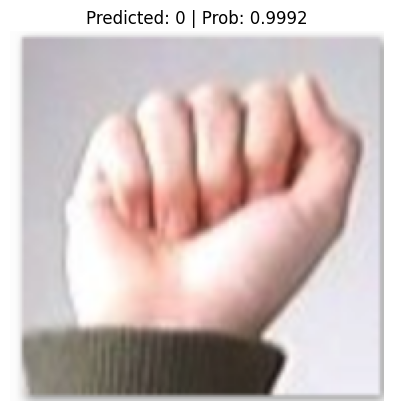

Predicted class: 0 | Probability: 0.9992


In [60]:
# 5. 테스트
test_img = "asl_images/a.png"  # 예측할 이미지 경로
pred_label, pred_prob = predict_image(test_img)
print(f"Predicted class: {pred_label} | Probability: {pred_prob:.4f}")

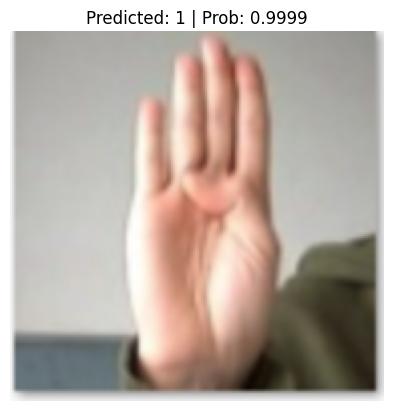

b.png: class 1, prob 0.9999


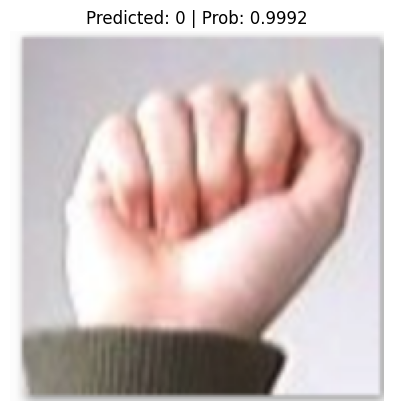

a.png: class 0, prob 0.9992


In [61]:
image_dir = Path("asl_images")
for img_path in image_dir.glob("*.png"):
    label, prob = predict_image(img_path)
    print(f"{img_path.name}: class {label}, prob {prob:.4f}")
